### Sources  
* https://medium.com/@traffordDataLab/lets-make-a-map-in-r-7bd1d9366098  
* https://stackoverflow.com/questions/50859765/chloropleth-map-with-geojson-and-ggplot2  
* https://www.r-graph-gallery.com/327-chloropleth-map-from-geojson-with-ggplot2.html  

### SF issues  
* https://github.com/r-spatial/sf/issues/245
* copy/pasted gdal files from /home/anaconda3/pkgs/librgdal2-3-.../share/gdal to filepath at `Sys.getenv("GDAL_DATA")`
    * Did not override those already there...

In [46]:
library(sf)
library(ggplot2)
library(dplyr)
library(viridis)
library(tidyr)
library(gghighlight)
library(plotly)
library(tidyverse)
print('nice')

[1] "nice"


In [47]:
# Load map data
cp_map <- st_read("../data/central_park_geo.geojson", quiet = TRUE)

In [48]:
# Update values for different zones of CP West
cp_map$location <- as.character(cp_map$location)
cp_map$sitename <- as.character(cp_map$sitename)
cp_map$sitename[cp_map$location == 'CPW, W 97 St, West Drive, W 100 St'] <- 'Central Park West (Zone 1)'
cp_map$sitename[cp_map$location == 'CPW, 85 St Transverse, West Drive To 96 St'] <- 'Central Park West (Zone 2)'
cp_map$sitename[cp_map$location == 'West Drive, CPW, 65 St Transverse'] <- 'Central Park West (Zone 3)'
cp_map$sitename[cp_map$location == '66 St To 72 St, CPW To West Drive'] <- 'Central Park West (Zone 4)'

# Add numbers for each zone to display on map 
cp_map$number <- seq(1:63)

In [49]:
# Read in squirrel data
squirrel_data <- read.csv('../data/squirrel_data.csv')

In [50]:
# Filter data for counts about 5 squirrels
gt_5_sq <- squirrel_data %>% select(sitename, Unique_Squirrel_ID) %>% filter(Unique_Squirrel_ID > 5) %>% pull(sitename)

In [51]:
# Find center of each polygon to plot region number
centroids_filtered <- cp_map %>%
    filter((sitename %in% gt_5_sq)) %>%
    st_centroid() %>% 
    bind_cols(as_data_frame(st_coordinates(.)))

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”Warning message in st_centroid.sfc(st_geometry(x), of_largest_polygon = of_largest_polygon):
“st_centroid does not give correct centroids for longitude/latitude data”

In [52]:
# Update positions of centroids on map
centroids_filtered$X[centroids_filtered$number == 52] <- -73.9581129527627
centroids_filtered$Y[centroids_filtered$number == 52] <- 40.7998257114188
centroids_filtered$X[centroids_filtered$number == 23] <- -73.973088868377
centroids_filtered$Y[centroids_filtered$number == 23] <- 40.7787970822199
centroids_filtered$X[centroids_filtered$number == 62] <- -73.9643990164278
centroids_filtered$X[centroids_filtered$number == 26] <- -73.9664505849341
centroids_filtered$X[centroids_filtered$number == 63] <- -73.9512081624995
centroids_filtered$Y[centroids_filtered$number == 51] <- 40.7698840126662
centroids_filtered$X[centroids_filtered$number == 53] <- -73.9690122680823

In [53]:
#Join map boundaries to squirrel data
data_map <- left_join(cp_map %>% filter(sitename %in% gt_5_sq), squirrel_data, by = 'sitename')

Warning message:
“Column `sitename` joining character vector and factor, coercing into character vector”

In [54]:
# Change certain colnames
colnames(data_map) <- c('propname',
'us_congres',
'zipcode',
'acres',
'location',
'gispropnum',
'retired',
'subcategor',
'communityb',
'department',
'precinct',
'retireddat',
'omppropid',
'nys_assemb',
'sitename',
'nys_senate',
'councildis',
'borough',
'descriptio',
'number',
'X',
'Unique_Squirrel_ID',
'Climbing',
'Approaching_humans',
'Vocalizing',
'Running_or_chasing',
'Eating_or_foraging',
'Count_diff',
'geometry')

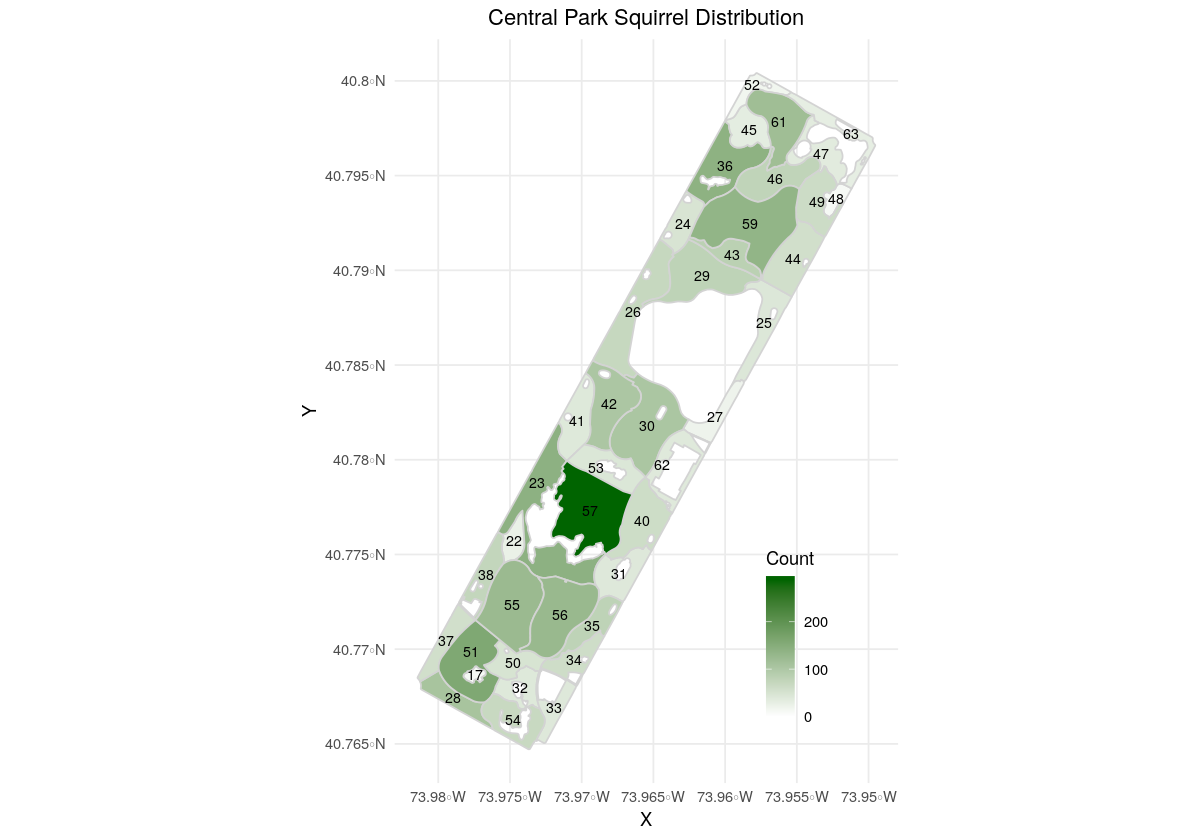

In [55]:
#' Plots a choropleth of central park filled with color
#' according to count of squirrels. 
#'
#' @param highlight (optional) a character vector of sitenames to highlight
#'
#' @return ggplot chart
#'
#' @examples
#' plot_choropleth(c('Ross Pinetum', 'The Ramble'))
plot_choropleth <- function(highlight = vector()) {
    full_map <- ggplot(data_map) + 
        geom_sf(aes(fill = Unique_Squirrel_ID), color = 'lightgrey') + 
        geom_text(aes(X, Y, label = number), 
                  data = centroids_filtered, 
                  size = 3, 
                  color = 'black') +
        scale_fill_gradient(low = 'white', high = 'darkgreen', 
                            limits = c(0,max(squirrel_data$Unique_Squirrel_ID)),
                            name = 'Count') +
        labs(title = 'Central Park Squirrel Distribution') +
        theme_minimal() +
        theme(legend.position = c(0.8, 0.2), plot.title = element_text(hjust = 0.5))
    if (length(highlight) == 0) {
        full_map
    } else {
        full_map + 
        gghighlight(sitename %in% c('The Ramble', 'Ross Pinetum'), 
                    label_key = Unique_Squirrel_ID)
    }
}

plot_choropleth()

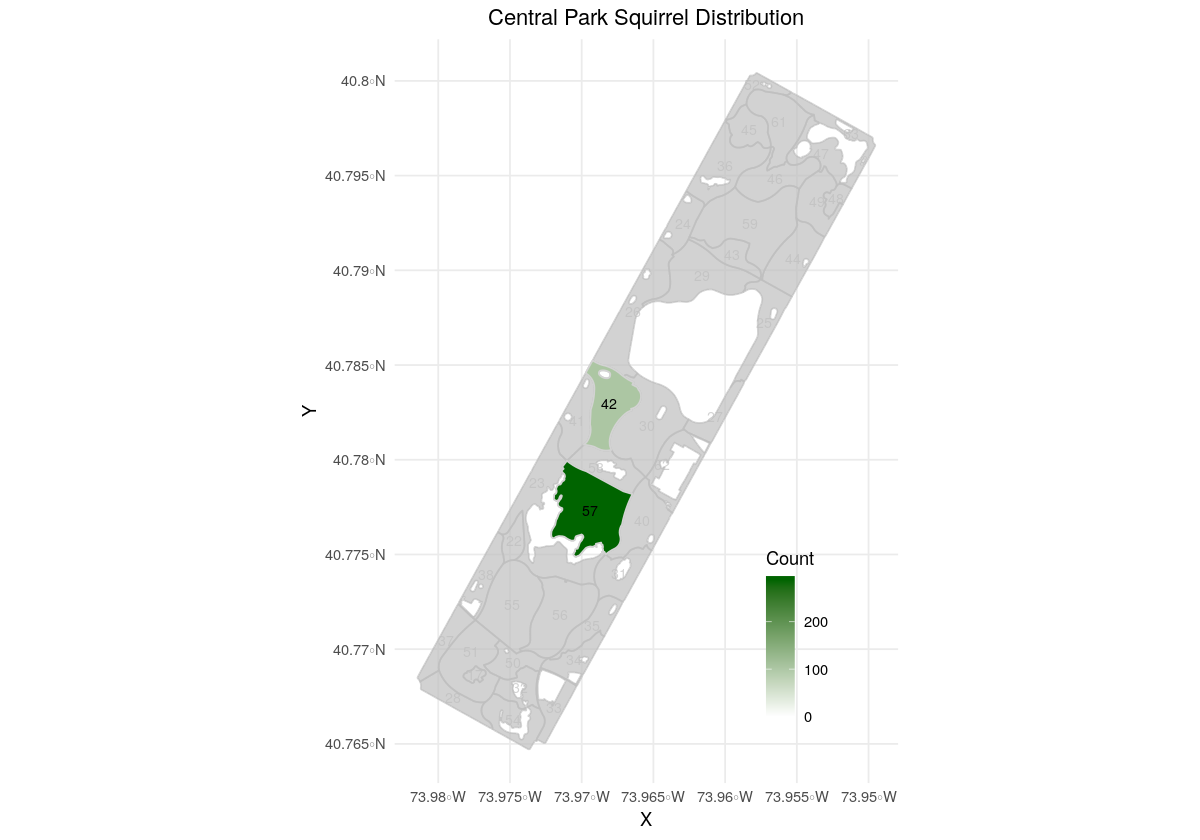

In [33]:
plot_choropleth(c('Ross Pinetum', 'The Ramble'))

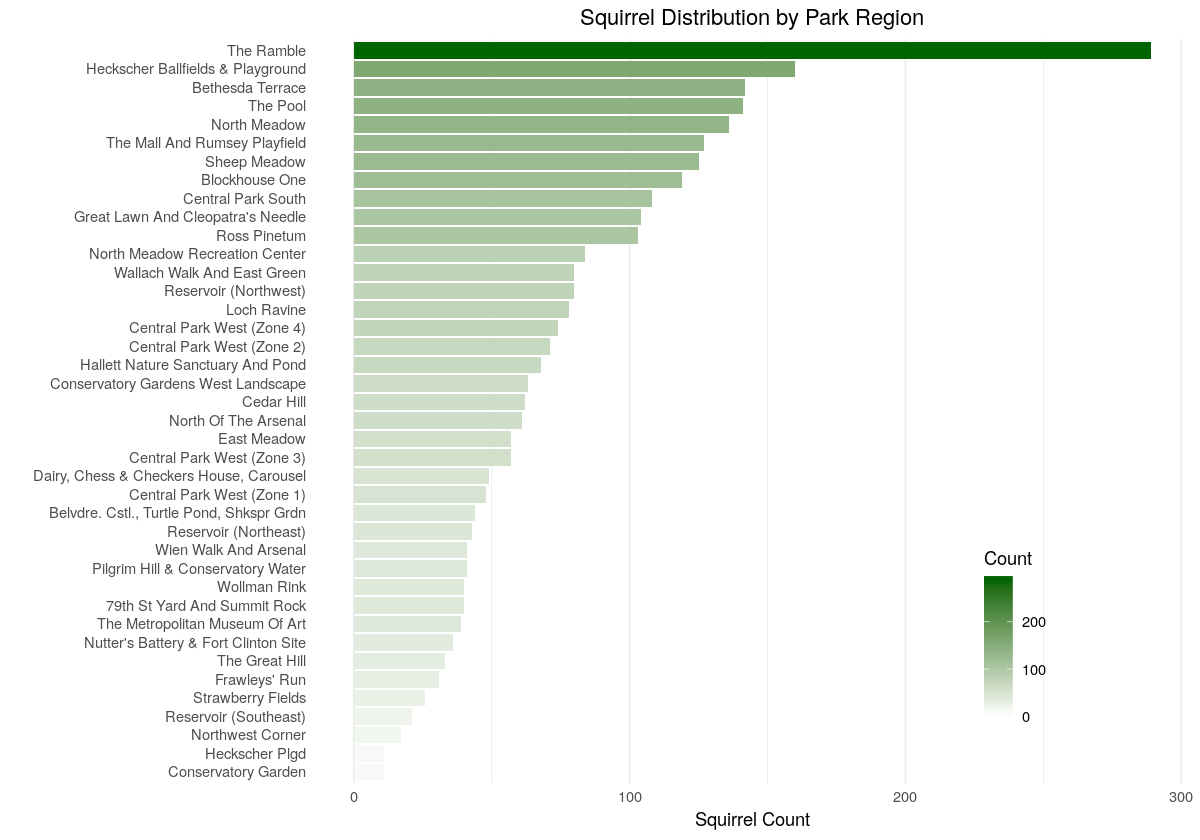

In [34]:
options(repr.plot.width=10)
#' Plots a bar chart of squirrel count by park region
#'
#' @param highlight (optional) a character vector of sitenames to highlight
#'
#' @return ggplot chart
#'
#' @examples
#' plot_counts_bar(c('Ross Pinetum', 'The Ramble'))
plot_counts_bar <- function(highlight = vector()) {
    counts_full <- ggplot(data_map) + 
            geom_bar(aes(x = reorder(sitename, Unique_Squirrel_ID), 
                         y = Unique_Squirrel_ID, 
                         fill = Unique_Squirrel_ID), 
                     stat = 'identity') + 

            coord_flip() +
            scale_fill_gradient(low = 'white', 
                                high = 'darkgreen', 
                                limits = c(0,max(squirrel_data$Unique_Squirrel_ID)),
                                name = 'Count') +
            labs(title = 'Squirrel Distribution by Park Region', y = 'Squirrel Count', x = '') +
            theme_minimal() +
            theme(panel.grid.major.y = element_blank(), legend.position = c(0.8, 0.2), plot.title = element_text(hjust = 0.5))
    if (length(highlight) == 0) {
        counts_full
        } else {
            counts_full +
                 gghighlight(sitename %in% highlight, 
                             label_key = Unique_Squirrel_ID)
    }
}

plot_counts_bar()

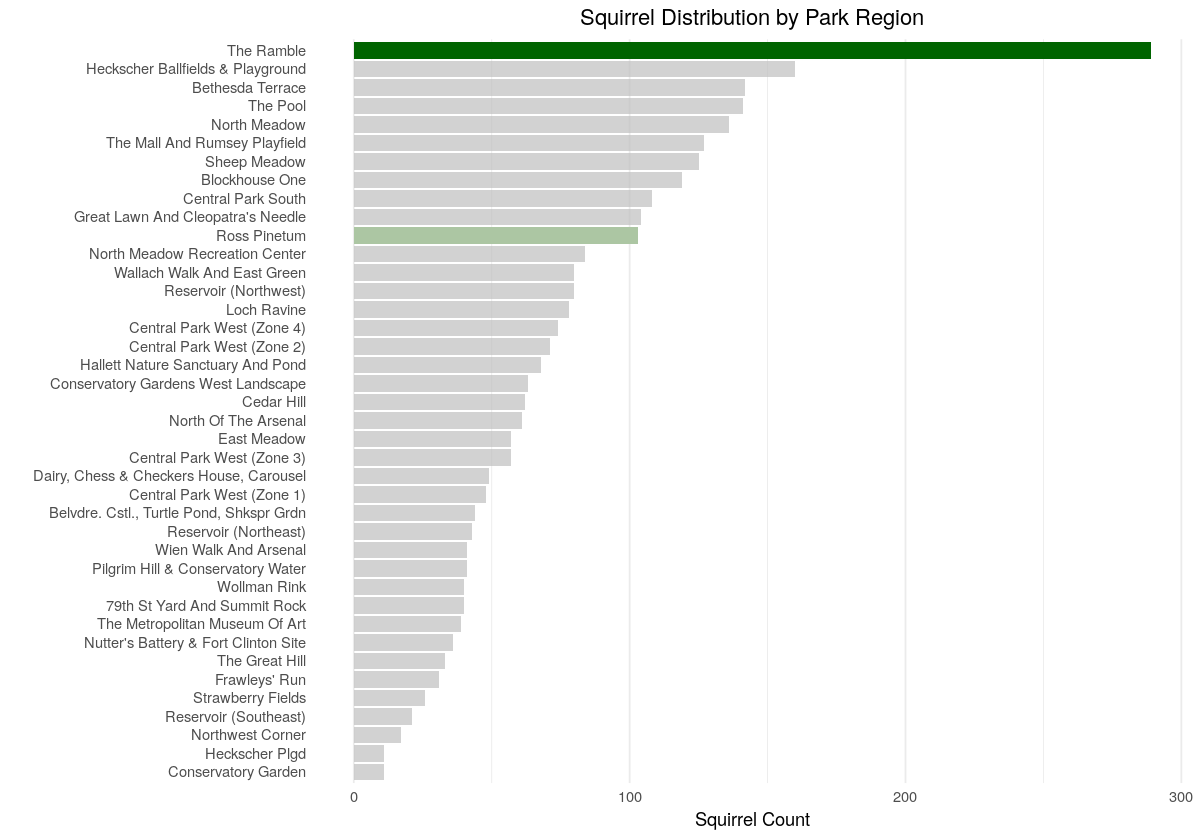

In [35]:
plot_counts_bar(c('Ross Pinetum', 'The Ramble'))

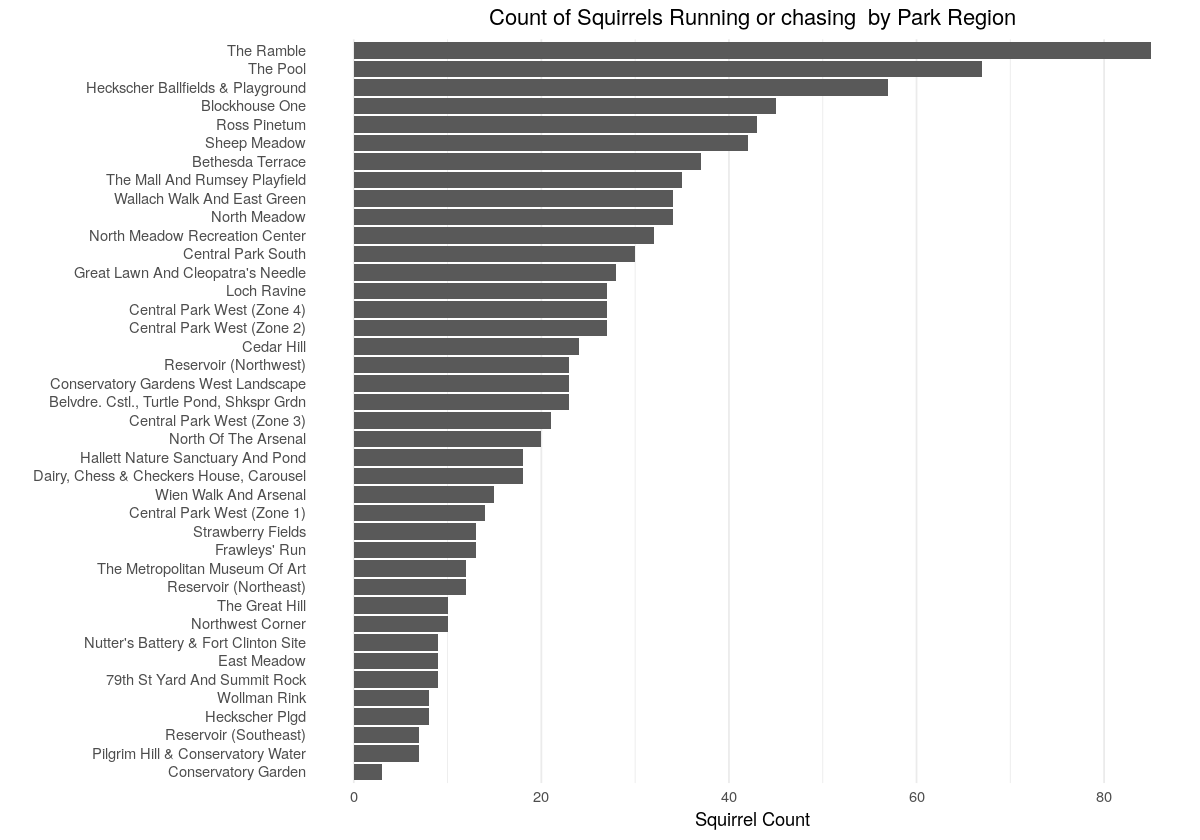

In [36]:
options(repr.plot.width=10)
#' Plots a bar chart of squirrel behavior by park region
#'
#' @param highlight (default = empty) a character vector of sitenames to highlight
#' @param behavior (default = Running_or_chasing) column of behavior to plot with options
#'       Running_or_chasing, Eating_or_foraging, Vocalizing, Approaching_humans, Climbing
#'
#' @return ggplot chart
#'
#' @examples
#' plot_behaviors_bar(c('Ross Pinetum', 'The Ramble'))
plot_behaviors_bar <- function(behavior = Running_or_chasing, highlight = vector()) {
    yvar <- enquo(behavior)
    b_bar <- ggplot(data_map) + 
        geom_bar(aes(reorder(sitename, !!yvar), 
                     !!yvar),
                     stat = 'identity') + 
        coord_flip() +
        labs(title = paste('Count of Squirrels',
                           str_replace_all(deparse(substitute(behavior)),
                                           '_', 
                                           ' '),
                           ' by Park Region'), 
             y = 'Squirrel Count', x = '') +
        theme_minimal() +
        theme(panel.grid.major.y = element_blank(), 
              plot.title = element_text(hjust = 0.5))
    if (length(highlight) == 0) {
        b_bar
    } else {
        b_bar + gghighlight(sitename %in% highlight, 
            label_key = Unique_Squirrel_ID)
    }
}



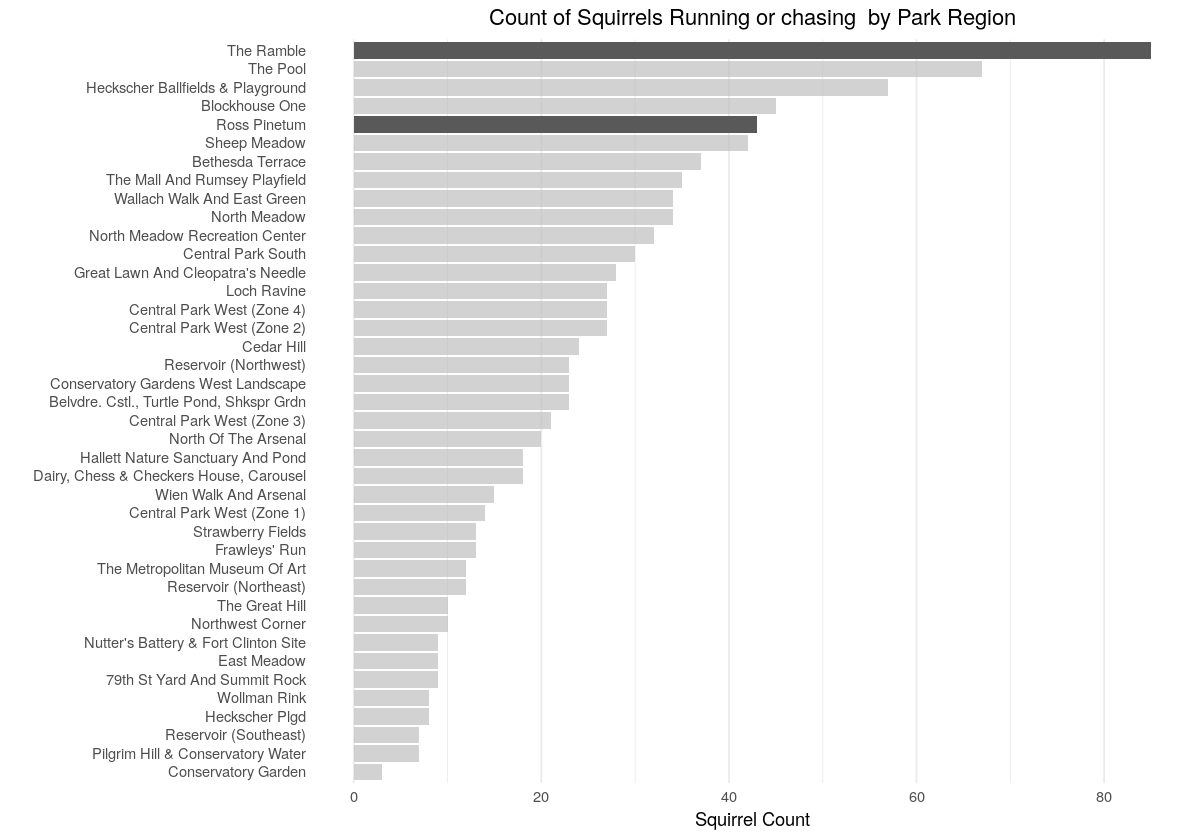

In [45]:
plot_behaviors_bar(highlight = c('Ross Pinetum', 'The Ramble'))

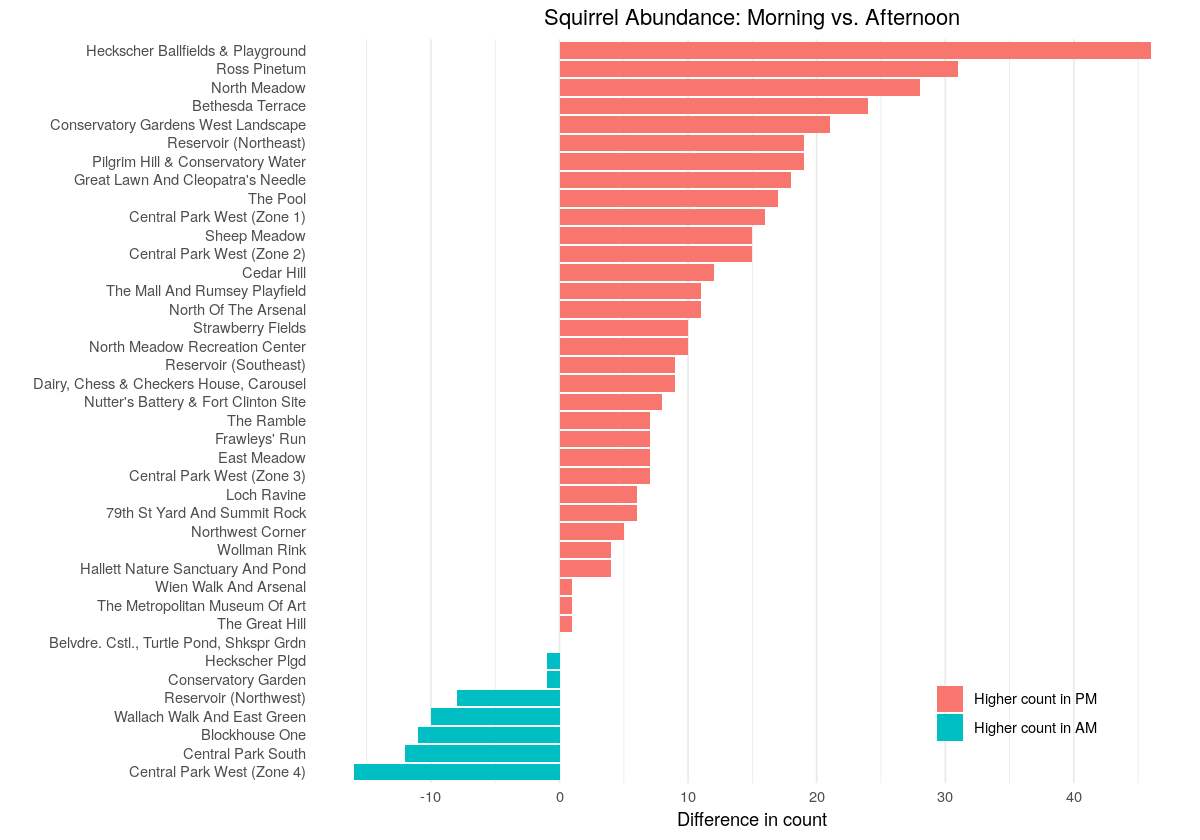

In [39]:
options(repr.plot.width=10)
#' Plots a bar chart of change in squirrel count from AM to PM
#'    by park region
#'
#' @param highlight (optional) a character vector of sitenames to highlight
#'
#' @return ggplot chart
#'
#' @examples
#' plot_diff_bar(c('Ross Pinetum', 'The Ramble'))
plot_diff_bar <- function(highlight = vector()) {
    diff_bar <- ggplot(data_map,
               aes(x = reorder(sitename, -Count_diff), 
                   y = -Count_diff,
                   fill = Count_diff > 0)) +
        geom_bar(stat = "identity") +
        scale_fill_discrete(name = NULL, 
                            labels = c("Higher count in PM", "Higher count in AM")) +
        labs(title = 'Squirrel Abundance: Morning vs. Afternoon', 
             y = 'Difference in count', 
             x = '') +
        scale_y_continuous(breaks=seq(-20,50,10)) +
        coord_flip() +
        theme_minimal() +
        theme(panel.grid.major.y = element_blank(), 
              legend.position = c(0.8, 0.1), 
              plot.title = element_text(hjust = 0.5))
    if (length(highlight) == 0){
        diff_bar
    } else {
        diff_bar + gghighlight(sitename %in% highlight, 
            label_key = Unique_Squirrel_ID)
    }
}
plot_diff_bar()

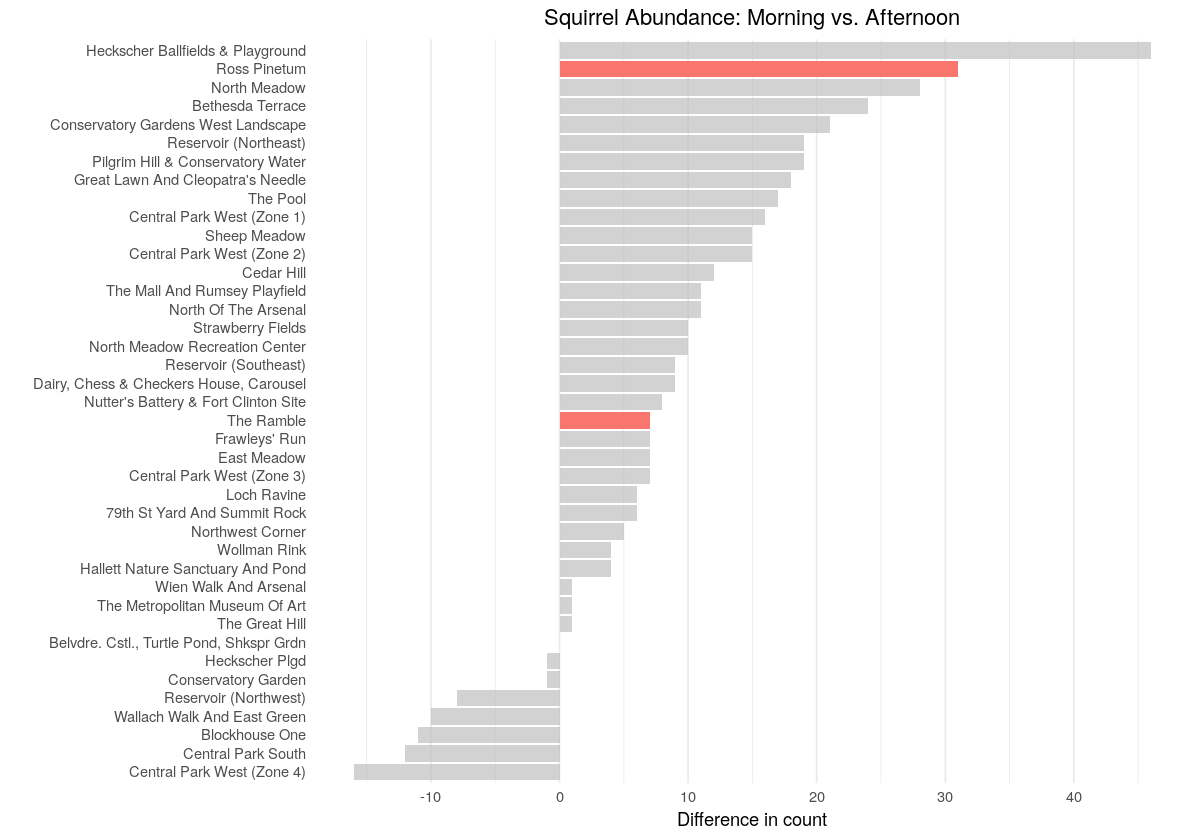

In [38]:
plot_diff_bar(c('Ross Pinetum', 'The Ramble'))